2. Feature Engineering I (10%)

In [239]:
import pandas as pd
import numpy as np
import math
import requests
import json
import os
from matplotlib import pyplot as plt
import seaborn as sns

In [240]:
df = pd.read_csv(r'C:\Users\chait\OneDrive\Documents\School\IFT_6758\2.Project\Milestone2_Draft\data_phase2\tidy_df.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408783 entries, 0 to 408782
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   game_id                    408783 non-null  int64  
 1   season                     408783 non-null  int64  
 2   season_type                408783 non-null  object 
 3   event_id                   408783 non-null  int64  
 4   home_team                  408783 non-null  object 
 5   away_team                  408783 non-null  object 
 6   home_team_side_1st_period  399561 non-null  object 
 7   attacking_team             408783 non-null  object 
 8   attacking_player           408783 non-null  object 
 9   goalie                     406884 non-null  object 
 10  period                     408783 non-null  int64  
 11  period_time                408783 non-null  object 
 12  goal_ind                   408783 non-null  int64  
 13  shot_ind                   40

“shot angle” measure is the angle at which the goal, shot, or miss came from; this can range from -90 to 90. Imagine you are standing where the goalie does on the ice. Straight ahead of you would be 0 degrees, perfectly right would be 90, and perfectly left would be -90

Ref: https://thecommutesports.com/2019/10/01/nhl-goalie-analysis/

In [241]:
# Angle of the shot added to the dataframe
# df['angle_from_net'] = np.arcsin(df['y_coordinates'].abs()/df['distance_from_net'])*180/math.pi

list_angle = []
for i in range(0,df.shape[0]):

    if df.attacking_team_side[i] == "right":
        if df.y_coordinates[i] == 0:
            list_angle.append(0)
        elif df.y_coordinates[i] > 0:
            list_angle.append(np.arcsin(df.y_coordinates[i]/df.distance_from_net[i])*-180/math.pi)
        else:
            list_angle.append(np.arcsin(df.y_coordinates[i]/df.distance_from_net[i])*-180/math.pi)
            
    elif df.attacking_team_side[i] == "left":
        if df.y_coordinates[i] == 0:
            list_angle.append(0)
        elif df.y_coordinates[i] > 0:
            list_angle.append(np.arcsin(df.y_coordinates[i]/df.distance_from_net[i])*180/math.pi)
        else:
            list_angle.append(np.arcsin(df.y_coordinates[i]/df.distance_from_net[i])*180/math.pi)
df['angle_from_net'] = list_angle


In [242]:
df.head()

,game_id,season,season_type,event_id,home_team,away_team,home_team_side_1st_period,attacking_team,attacking_player,goalie,...,shot_ind,x_coordinates,y_coordinates,shot_type,empty_net,strength,gwg,distance_from_net,attacking_team_side,angle_from_net
0,2015020001,20152016,R,7,Toronto Maple Leafs,Montréal Canadiens,right,Toronto Maple Leafs,Brad Boyes,Carey Price,...,1,-55.0,6.0,Wrist Shot,NaN,NaN,NaN,34.525353,right,-10.007980
1,2015020001,20152016,R,9,Toronto Maple Leafs,Montréal Canadiens,right,Toronto Maple Leafs,Nazem Kadri,Carey Price,...,1,-79.0,0.0,Snap Shot,NaN,NaN,NaN,10.000000,right,0.000000
2,2015020001,20152016,R,10,Toronto Maple Leafs,Montréal Canadiens,right,Toronto Maple Leafs,Nazem Kadri,Carey Price,...,1,-75.0,-1.0,Snap Shot,NaN,NaN,NaN,14.035669,right,4.085617
3,2015020001,20152016,R,13,Toronto Maple Leafs,Montréal Canadiens,right,Toronto Maple Leafs,Daniel Winnik,Carey Price,...,1,-55.0,-36.0,Wrist Shot,NaN,NaN,NaN,49.517674,right,46.636577
4,2015020001,20152016,R,21,Toronto Maple Leafs,Montréal Canadiens,right,Toronto Maple Leafs,Joffrey Lupul,Carey Price,...,1,-61.0,-1.0,Tip-In,NaN,NaN,NaN,28.017851,right,2.045408


In [243]:
# Imputing empty net data in existing dataframe

df['empty_net'] = df['empty_net'].replace(np.nan,0)
df['empty_net'] = df['empty_net'].replace(True,1)
df['empty_net'] = df['empty_net'].replace(False,0)

In [244]:
df = df[~df['distance_from_net'].isnull()] # distance was null for 17 rows
df = df[~df['angle_from_net'].isnull()] # angle was null for 18 rows

In [245]:
# training (train+validation sets for model) and test tests creation

df_train = df[df['season'] != 20192020]
df_test = df[df['season'] == 20192020]

In [246]:
df_train_nogoals = df_train[df_train['shot_ind']==1]
df_train_goals = df_train[df_train['goal_ind']==1]

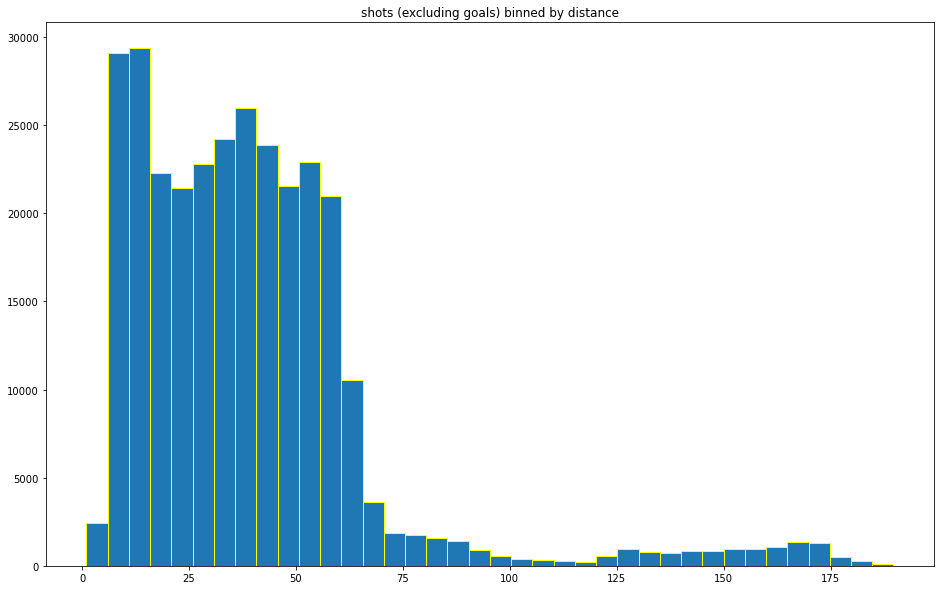

In [376]:
fig = plt.figure(figsize=(35,10))
plt.subplot(121)
plt.hist(df_train_nogoals['distance_from_net'], edgecolor="yellow", bins=math.ceil((df_train_nogoals['distance_from_net'].max() - df_train_nogoals['distance_from_net'].min())/5))
plt.title("shots (excluding goals) binned by distance")
plt.show()


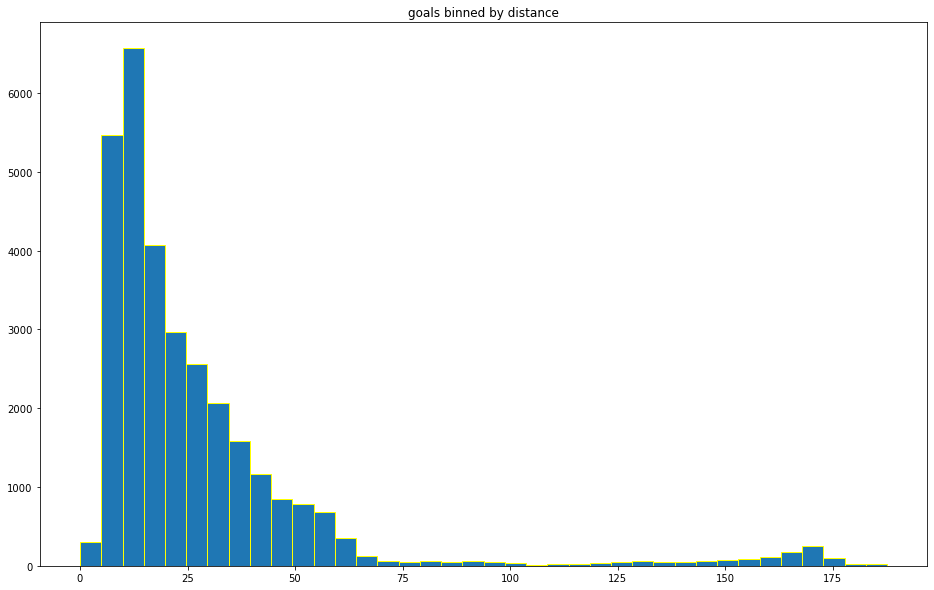

In [377]:
fig = plt.figure(figsize=(35,10))
plt.subplot(121)
plt.hist(df_train_goals['distance_from_net'], edgecolor="yellow", bins=math.ceil((df_train_goals['distance_from_net'].max() - df_train_goals['distance_from_net'].min())/5))
plt.title("goals binned by distance")
plt.show()

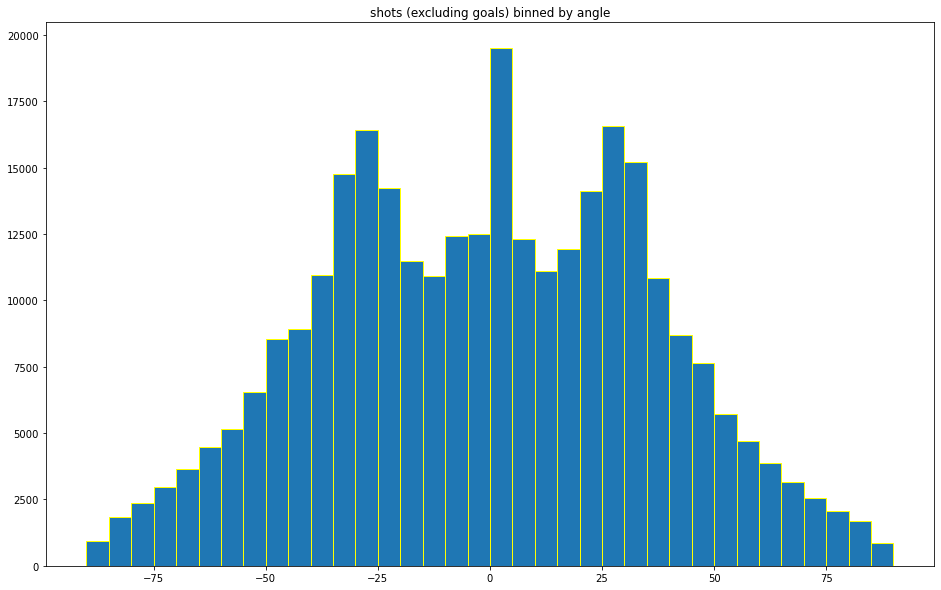

In [249]:
fig = plt.figure(figsize=(35,10))
plt.subplot(121)
plt.hist(df_train_nogoals['angle_from_net'], edgecolor="yellow", bins=math.ceil((df_train_nogoals['angle_from_net'].max() - df_train_nogoals['angle_from_net'].min())/5))
plt.title("shots (excluding goals) binned by angle")
plt.show()


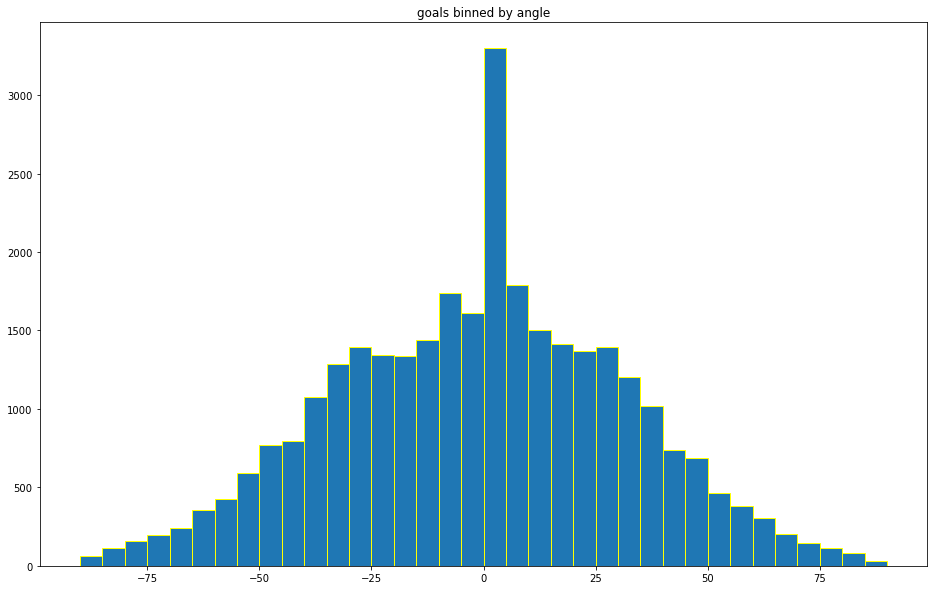

In [378]:
fig = plt.figure(figsize=(35,10))
plt.subplot(121)
plt.hist(df_train_goals['angle_from_net'],edgecolor="yellow", bins=math.ceil((df_train_goals['angle_from_net'].max() - df_train_goals['angle_from_net'].min())/5))
plt.title("goals binned by angle")
plt.show()


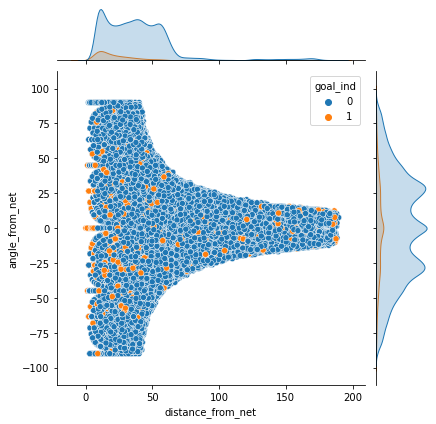

In [251]:
# Joint plot showing the relation between distance of the shot and angle of the shot
sns.jointplot(data=df_train, x="distance_from_net", y="angle_from_net", hue="goal_ind")


<ipython-input-252-d53752cc87d7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['distance_from_net_bucket'] = pd.qcut(df_train['distance_from_net'], n_buckets, labels = False) +1
<ipython-input-252-d53752cc87d7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['angle_from_net_bucket'] = pd.qcut(df_train['angle_from_net'], n_buckets, labels = False) +1
<ipython-input-252-d53752cc87d7>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GU

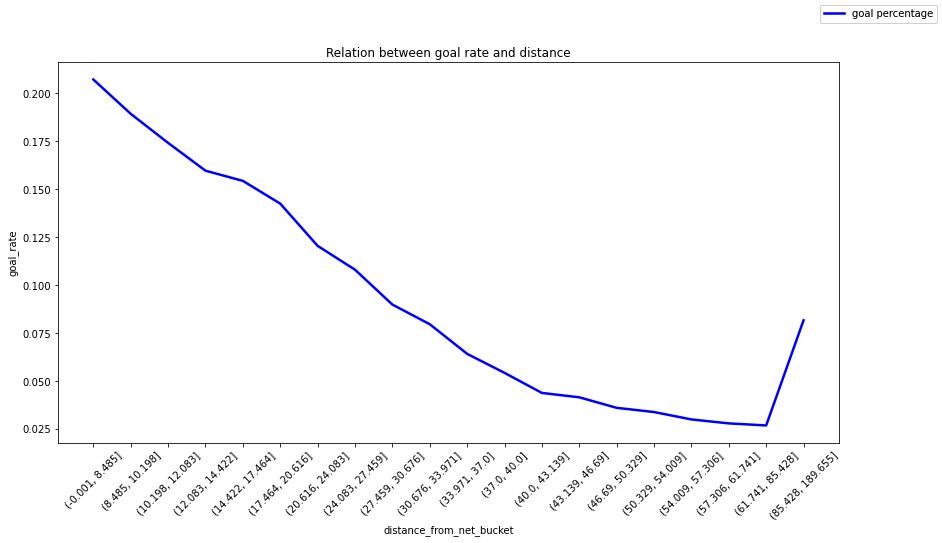

In [252]:
# Relation between goal rate and distance


n_buckets = 20

df_train['distance_from_net_bucket'] = pd.qcut(df_train['distance_from_net'], n_buckets, labels = False) +1
df_train['angle_from_net_bucket'] = pd.qcut(df_train['angle_from_net'], n_buckets, labels = False) +1

intervals = list(set(pd.qcut(df_train['distance_from_net'], n_buckets)))
intervals.sort()
intervals = [str(interval) for interval in intervals]


intervals_ang = list(set(pd.qcut(df_train['angle_from_net'], n_buckets)))
intervals_ang.sort()
intervals_ang = [str(interval_ang) for interval_ang in intervals_ang]

df_train_copy = df_train.copy()
df_train_copy['shot_count'] = 1

df_train_copy1 = df_train_copy[['goal_ind','shot_count','distance_from_net_bucket']].groupby(['distance_from_net_bucket']).sum().reset_index()
df_train_copy1['goal_rate'] = df_train_copy1['goal_ind']/df_train_copy1['shot_count']

y1_max = max(df_train_copy1['goal_rate'])

fig = plt.figure(figsize = (14,7))
ax = sns.lineplot(x = 'distance_from_net_bucket', y = 'goal_rate', label='goal percentage', data = df_train_copy1, color='b', legend = False, linewidth = 2.5)
ax.set_xticks(range(1,n_buckets+1))
ax.set_xticklabels(intervals, rotation = 45)
ax.set_ylim(bottom=0, top=y1_max * 1.1)
fig.legend(loc="upper right")
plt.title(f"Relation between goal rate and distance")
fig.legend(loc="upper right")
plt.autoscale()
fig.show()
#fig.savefig("../../ift6758-blog-template-main/figures/question_5_2_"+str(i)+".png", bbox_inches = 'tight')


<ipython-input-254-84c5a50b1062>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


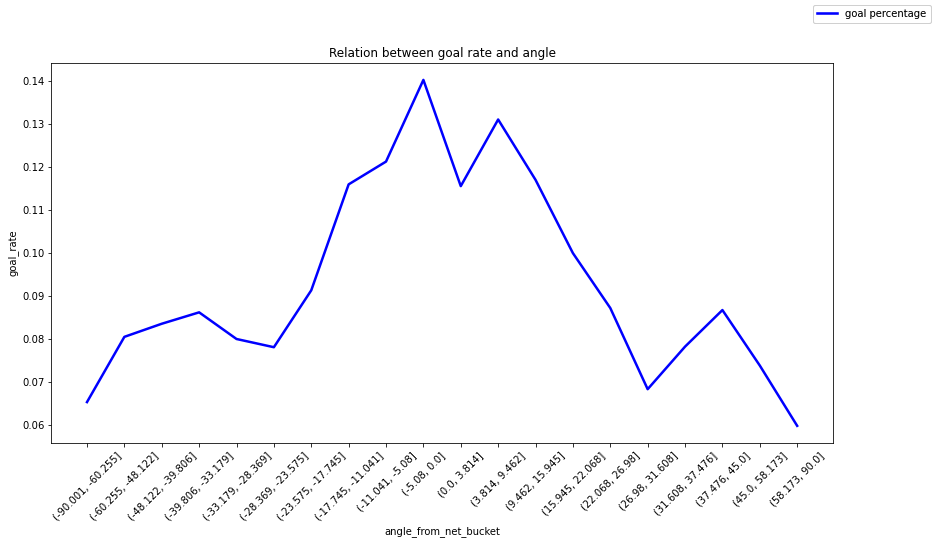

In [254]:
# Relation between goal rate and angle

df_train_copy2 = df_train_copy[['goal_ind','shot_count','angle_from_net_bucket']].groupby(['angle_from_net_bucket']).sum().reset_index()
df_train_copy2['goal_rate'] = df_train_copy2['goal_ind']/df_train_copy2['shot_count']

y2_max = max(df_train_copy2['goal_rate'])

fig = plt.figure(figsize = (14,7))
ax = sns.lineplot(x = 'angle_from_net_bucket', y = 'goal_rate', label='goal percentage', data = df_train_copy2, color='b', legend = False, linewidth = 2.5)
ax.set_xticks(range(1,n_buckets+1))
ax.set_xticklabels(intervals_ang, rotation = 45)
ax.set_ylim(bottom=0, top=y2_max * 1.1)
fig.legend(loc="upper right")
plt.title(f"Relation between goal rate and angle")
fig.legend(loc="upper right")
plt.autoscale()
fig.show()

In [255]:
#goals only to be binned by distance for empty net and non-empty net events

df_train_empty_net = df_train[(df_train['empty_net']==1) & (df_train['goal_ind']==1)]
df_train_non_empty_net = df_train[(df_train['empty_net']==0) & (df_train['goal_ind']==1)]
df_train_empty_net.shape

(1525, 25)

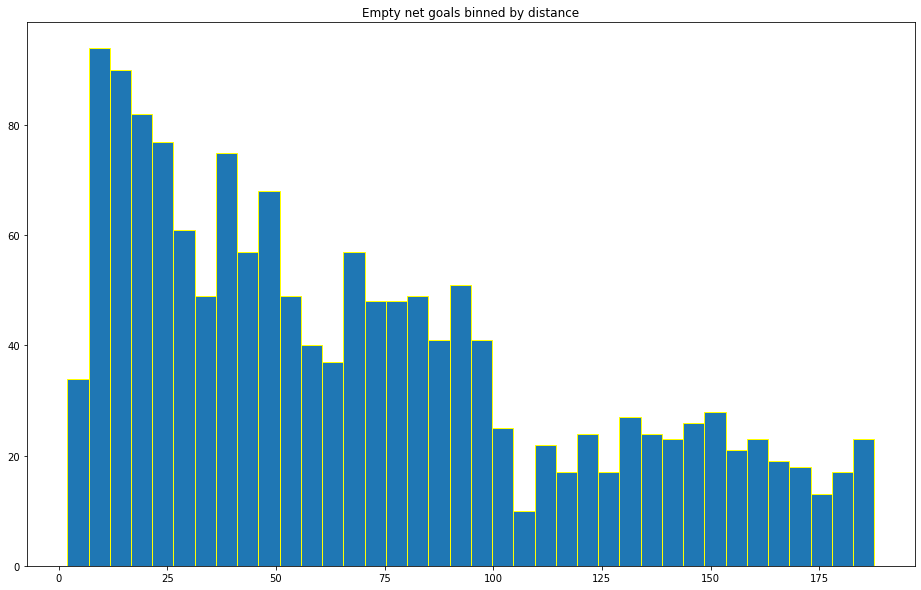

In [379]:
fig = plt.figure(figsize=(35,10))
plt.subplot(121)
plt.hist(df_train_empty_net['distance_from_net'], edgecolor="yellow", bins=math.ceil((df_train_empty_net['distance_from_net'].max() - df_train_empty_net['distance_from_net'].min())/5))
plt.title("Empty net goals binned by distance")
plt.show()

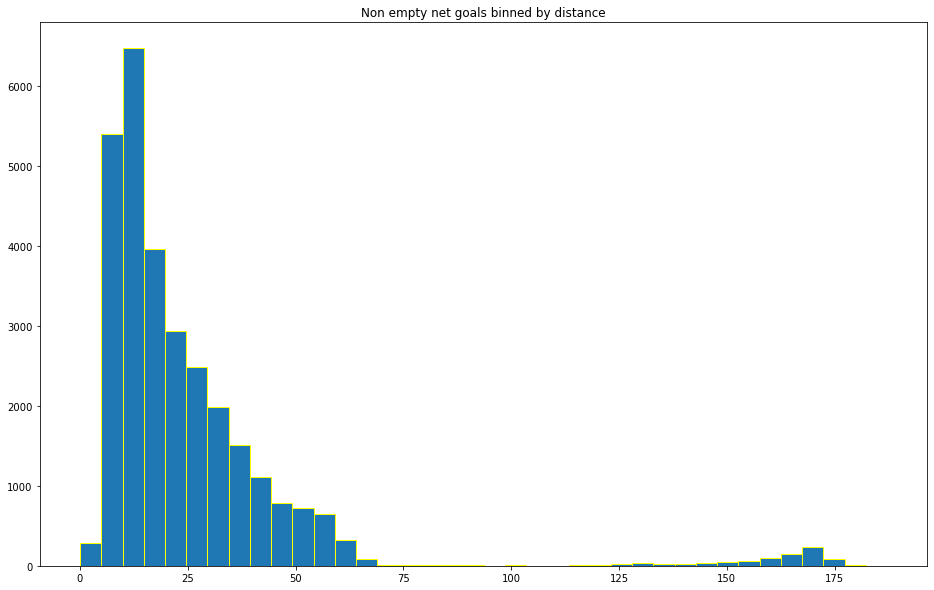

In [380]:
fig = plt.figure(figsize=(35,10))
plt.subplot(121)
plt.hist(df_train_non_empty_net['distance_from_net'], edgecolor="yellow", bins=math.ceil((df_train_non_empty_net['distance_from_net'].max() - df_train_non_empty_net['distance_from_net'].min())/5))
plt.title("Non empty net goals binned by distance")
plt.show()

In [258]:
# events that have incorrect features (e.g. wrong x/y coordinates) validated by the NHL gamecenter video clips


df_goals = df[df['goal_ind']==1]
df_goals_anomaly = df_goals[(df_goals['x_coordinates'].abs()>89)&(df_goals['distance_from_net']>=150)&(df_goals['empty_net']==0)]
df_goals_anomaly

,game_id,season,season_type,event_id,home_team,away_team,home_team_side_1st_period,attacking_team,attacking_player,goalie,...,shot_ind,x_coordinates,y_coordinates,shot_type,empty_net,strength,gwg,distance_from_net,attacking_team_side,angle_from_net
4192,2015020071,20152016,R,139,New York Islanders,San Jose Sharks,left,New York Islanders,Anders Lee,Alex Stalock,...,0,97.0,7.0,Backhand,0,Power Play,False,186.131674,right,-2.155276
9678,2015020163,20152016,R,315,Edmonton Oilers,Calgary Flames,left,Calgary Flames,Michael Frolik,Cam Talbot,...,0,93.0,26.0,Wrist Shot,0,Even,True,183.847763,right,-8.130102
15508,2015020261,20152016,R,240,New York Islanders,Arizona Coyotes,left,New York Islanders,John Tavares,Anders Lindback,...,0,-92.0,10.0,Wrist Shot,0,Even,True,181.276033,left,3.162298
22723,2015020383,20152016,R,134,Columbus Blue Jackets,Florida Panthers,left,Florida Panthers,Vincent Trocheck,Sergei Bobrovsky,...,0,-92.0,-20.0,Deflected,0,Even,False,182.101620,left,-6.305446
110213,2016020510,20162017,R,167,Florida Panthers,Detroit Red Wings,right,Florida Panthers,Derek MacKenzie,Jared Coreau,...,0,-97.0,21.0,Slap Shot,0,Even,False,187.181730,left,6.441600
404670,2019030145,20192020,P,212,Boston Bruins,Carolina Hurricanes,left,Boston Bruins,Patrice Bergeron,Petr Mrazek,...,0,98.0,14.0,Wrist Shot,0,Power Play,True,187.523332,right,-4.281536
404871,2019030154,20192020,P,101,Chicago Blackhawks,Vegas Golden Knights,right,Chicago Blackhawks,Matthew Highmore,Robin Lehner,...,0,97.0,21.0,Snap Shot,0,Even,True,187.181730,right,-6.441600
405627,2019030176,20192020,P,32,Calgary Flames,Dallas Stars,right,Calgary Flames,Johnny Gaudreau,Anton Khudobin,...,0,94.0,24.0,Wrist Shot,0,Power Play,False,184.567061,right,-7.471559
405972,2019030185,20192020,P,115,St. Louis Blues,Vancouver Canucks,left,St. Louis Blues,Ryan O'Reilly,Jacob Markstrom,...,0,-91.0,-7.0,Backhand,0,Even,False,180.136060,left,-2.227047


# 3. Baseline Models (15%)

In [259]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

<AxesSubplot:xlabel='goal_ind', ylabel='count'>

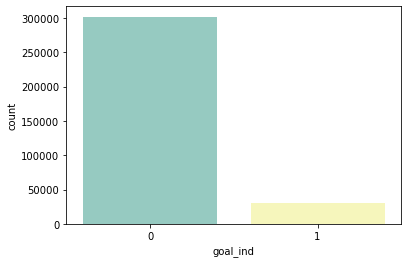

In [260]:
# Class 0 (no-goal) vs. Class 1 (goal) of the whole training set
sns.countplot(x='goal_ind', data = df_train, palette = 'Set3')

<AxesSubplot:xlabel='goal_ind', ylabel='count'>

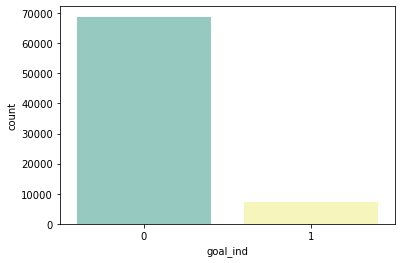

In [261]:
# Class 0 (no-goal) vs. Class 1 (goal) of the final test set

sns.countplot(x='goal_ind', data = df_test, palette = 'Set3')

<AxesSubplot:xlabel='shot_type', ylabel='count'>

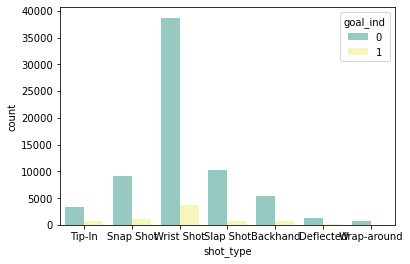

In [262]:
sns.countplot(x='shot_type', data = df_test, palette = 'Set3', hue = 'goal_ind')

In [371]:
# Functions

# Function1: Function to generate ROC curve with AUC metric

def curves(X_train,y_train,X_valid,y_valid,y_pred,predicted_prob):

#--------------------Determine ROC curve----------------------------------

    from sklearn.metrics import roc_curve, auc
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_valid, y_pred)
    roc_auc = auc(fpr, tpr)
#--------------------Determine Goal Rate (#goals / (#no_goals + #goals)) & cum_goal_rate ----------------------------------
    dummy_goal = []
    for i in y_valid:
        dummy_goal.append(i)
    df_goals = pd.DataFrame(dummy_goal, columns = ["goal_ind"])
# loop to get probabilities of 2 classes separately
    dummy_list = []
    for i in predicted_prob:
        dummy_list.append(i)
    df_prob = pd.DataFrame(dummy_list, columns = ["No_Goal_Prob","Goal_Prob"])
    df_new = pd.concat([df_goals, df_prob], axis=1)
    df_new['shot_count'] = 1
    df_new['percentile'] = df_new['Goal_Prob'].rank(pct=True)

# The goal rate (#goals / (#no_goals + #goals)) as a function of the shot probability model percentile
    total_goals = df_new['goal_ind'].sum()
    df_perc = []
    goal_count = []
    shot_count = []
    goal_rate = []
    cum_goal_rate = []
    pctile = []
    pctile_prop = []
    quantile_list = np.linspace(0,1,21).round(4).tolist()
    q = df_new.quantile(quantile_list)
    col = 'Goal_Prob'
    temp = 0
    for i in np.arange(5,101,5):
        df_perc = df_new[((df_new[col]>=q[col][(i-5)/100]) & (df_new[col]<q[col][i/100]))]
        goal_count.append(df_perc.goal_ind.sum())
        shot_count.append(df_perc.shot_count.sum())
        goal_rate.append(df_perc.goal_ind.sum()/df_perc.shot_count.sum())
        pctile.append(i/100)
        temp = temp + df_perc.goal_ind.sum()
        cum_goal_rate.append(temp/total_goals)
        pctile_prop.append(1-(i/100))
    df_perc_prop = pd.DataFrame(list(zip(goal_count,shot_count,goal_rate,pctile,cum_goal_rate,pctile_prop)),columns=['goal_count',"sum_shot_count",'goal_rate','pctile','proportion','pctile_prop'])

#--------------------plot figures 1----------------------------------
#    ax = plt.gca()
    plt.figure(figsize=(10,5))
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.3f)" % roc_auc,
        linestyle="-"
    )
    
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, label="Random Baseline", linestyle="--")
    
    plt.plot(
        df_perc_prop['pctile'],
        df_perc_prop['goal_rate'],
        color="green",
        lw=lw,
        label="goal rate",
        linestyle="-."
    )
    
    plt.plot(
        df_perc_prop['pctile'],
        df_perc_prop['proportion'],
        color="red",
        lw=lw,
        label="culumative goal rate",
        linestyle=":"
    )    
    
    plt.title(f'Feature {ele} trained with Logistic Regression')
    plt.legend()
    plt.show()
#--------------------plot figures 4----------------------------------
    disp = CalibrationDisplay.from_predictions(df_new.goal_ind,df_new.Goal_Prob,n_bins=200)
    plt.show()

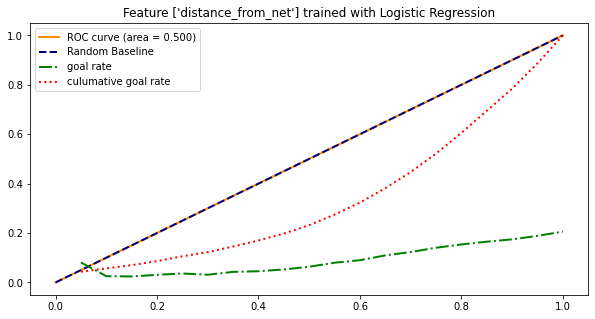

<Figure size 720x360 with 0 Axes>

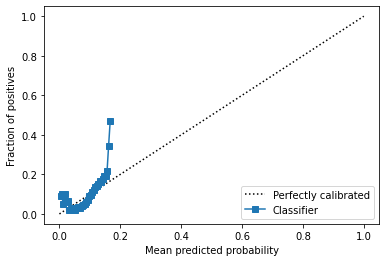

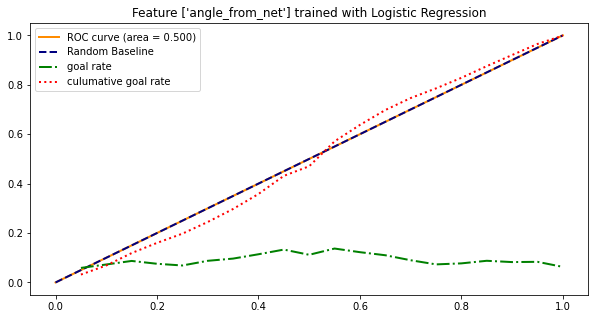

<Figure size 720x360 with 0 Axes>

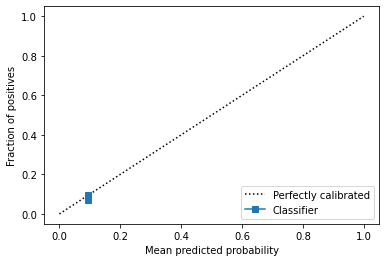

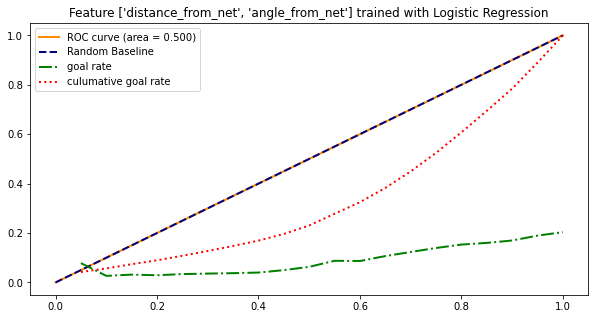

<Figure size 720x360 with 0 Axes>

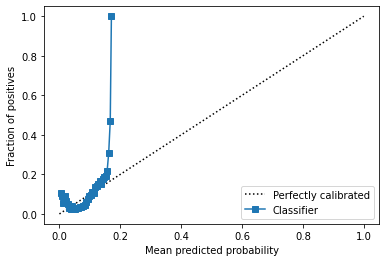

In [372]:
list_model_iter = [['distance_from_net'],
                   ['angle_from_net'],
                   ['distance_from_net','angle_from_net']
                  ]
for ele in list_model_iter:
    if df_train[ele].shape[1] == 1:
        X = df_train[ele].values.reshape(-1,1)
    else:
        X = df_train[ele].values
        
    y = df_train['goal_ind']
    X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.3)
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    cm = sklearn.metrics.confusion_matrix(y_valid, y_pred, labels=None, sample_weight=None, normalize=None)

# Loop to check number of goals predicted by classifier
    cnt = 0
    for i in range(len(X_valid)):
        if y_pred[i] == 1:
            cnt += 1
#    print(f'Number of goal events predicted by classifier with selected features {ele} is : {cnt} with accuracy score of {clf.score(X_train, y_train)} and {clf.score(X_valid, y_valid)} on training set and validation set respectively')
    
#Predicted Probabilities - Outputs probability for class 0 (not a goal event) and class (goal event)   
    predicted_prob = clf.predict_proba(X_valid)

# Plot ROC curve
    curves(X_train,y_train,X_valid,y_valid,y_pred,predicted_prob)


In [301]:
# Random Baseline
df_train_random = df_train[['goal_ind','shot_ind']].copy()
random_select = []
for ele in range(df_train.shape[0]):
    random_select.append(np.random.uniform(0, 1))  
df_train_random['Goal_Prob'] = random_select
df_train_random['shot_count'] = 1

<ipython-input-381-0ba06298aab8>:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


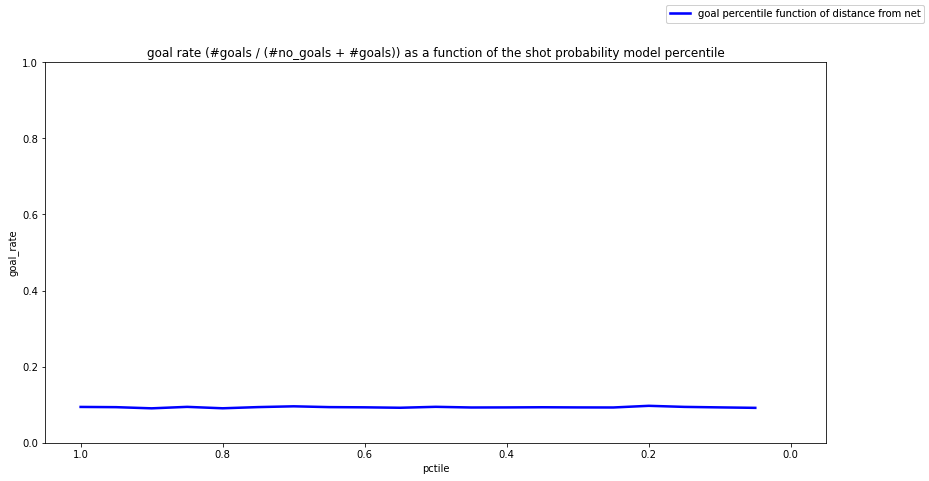

In [381]:
# The goal rate (#goals / (#no_goals + #goals)) as a function of the shot probability model percentile
total_goals = df_train_random['goal_ind'].sum()

df_perc = []

goal_count = []
shot_count = []
goal_rate = []
cum_goal_rate = []
pctile = []
pctile_prop = []
quantile_list = np.linspace(0,1,21).round(4).tolist()
q = df_train_random.quantile(quantile_list)
col = 'Goal_Prob'

temp = 0

for i in np.arange(5,101,5):
    df_perc = df_train_random[((df_train_random[col]>=q[col][(i-5)/100]) & (df_train_random[col]<q[col][i/100]))]
    goal_count.append(df_perc.goal_ind.sum())
    shot_count.append(df_perc.shot_count.sum())
    goal_rate.append(df_perc.goal_ind.sum()/df_perc.shot_count.sum())
    pctile.append(i/100)
    temp = temp + df_perc.goal_ind.sum()
    cum_goal_rate.append(temp/total_goals)
    pctile_prop.append(1-(i/100))
df_perc_prop = pd.DataFrame(list(zip(goal_count,shot_count,goal_rate,pctile,cum_goal_rate,pctile_prop)),columns=['goal_count',"sum_shot_count",'goal_rate','pctile','proportion','pctile_prop'])

y1_max = max(df_perc_prop['goal_rate'])

fig = plt.figure(figsize = (14,7))
ax = sns.lineplot(x = 'pctile', y = 'goal_rate', label='goal percentile function of distance from net', data = df_perc_prop, color='b', legend = False, linewidth = 2.5)
ax.set_xlim(left=1.05, right=-.05)
ax.set_ylim(bottom=0, top=1)
fig.legend(loc="upper right")
plt.title(f"goal rate (#goals / (#no_goals + #goals)) as a function of the shot probability model percentile")
fig.legend(loc="upper right")
#plt.autoscale()
fig.show()

<ipython-input-305-8ed434677780>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


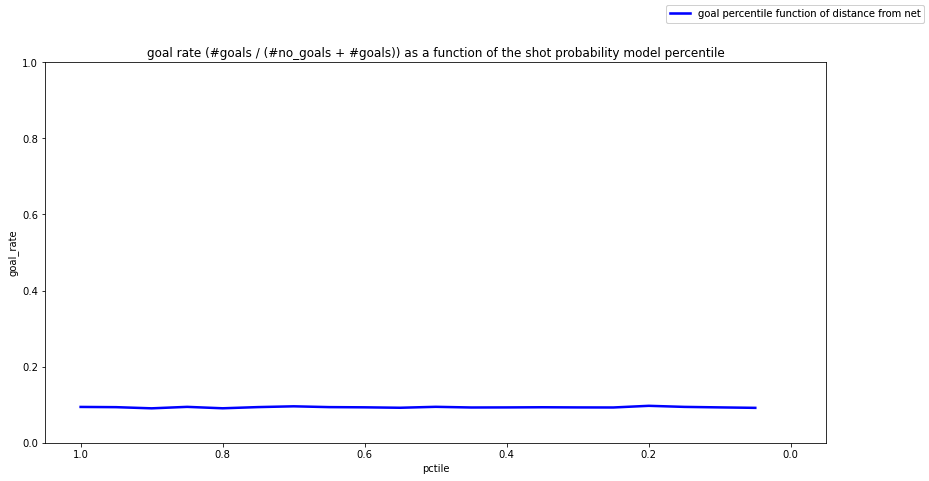

<ipython-input-382-fd3803df72b7>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


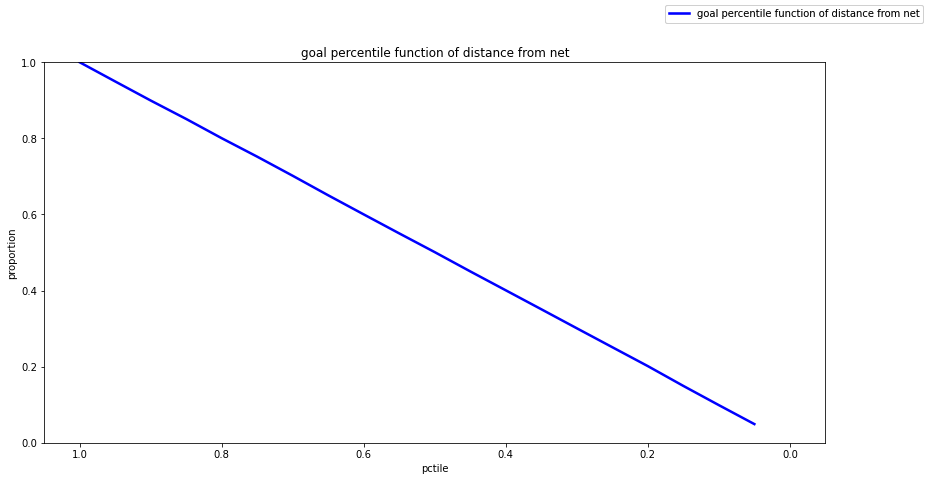

In [382]:
y1_max = max(df_perc_prop['proportion'])

fig = plt.figure(figsize = (14,7))
ax = sns.lineplot(x = 'pctile', y = 'proportion', label='goal percentile function of distance from net', data = df_perc_prop, color='b', legend = False, linewidth = 2.5)
ax.set_xlim(left=1.05, right=-.05)
ax.set_ylim(bottom=0, top=1)
fig.legend(loc="upper right")
plt.title(f"goal percentile function of distance from net")
fig.legend(loc="upper right")
#plt.autoscale()
fig.show()

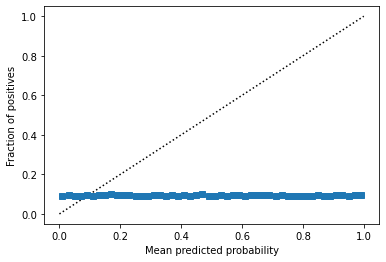

In [383]:
from sklearn.calibration import calibration_curve, CalibrationDisplay
prob_true, prob_pred = calibration_curve(df_train_random.goal_ind, df_train_random.Goal_Prob, n_bins=50)
disp = CalibrationDisplay(prob_true, prob_pred, df_train_random.Goal_Prob)
disp.plot()